In [11]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os
from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta

from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


# 4. Szilard engine test

In [12]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
from edward_tools.visualization import animate_sim_flux_qubit
import kyle_tools as kt
import matplotlib.pyplot as plt
import importlib, os, hashlib, json
from edward_tools import coupled_fq_protocol_library, cfq_runner

In [13]:
# from edward_tools import coupled_fq_protocol_library
# coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
# create_system = coupled_fq_protocol_library.create_system
# get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
# create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
# create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
# coupled_fq_runner = importlib.reload(cfq_runner)


In [14]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params['N'] = 50_00
params['dt'] = 1.0/10_00


zeroDissipation = False
if zeroDissipation:
    _lambda = _lambda * 0
    _eta = _eta * 0


In [15]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [16]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
# phi_1_dcx, phi_2_dcx = 3, 3
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

# gamma, beta_1, beta_2 = 0, 0, 0
gamma = 20
# d_beta_1, d_beta_2 = 0.6, 0.6
d_beta_1, d_beta_2 = 0, 0
params['sim_params'] = [_lambda, _theta, _eta]

# this is the initial parameter used
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx,  "phi_2_dcx": phi_2_dcx,
        "M_12": 0, 'x_c': x_c
}


# Time symmetric protocol
# THis part is how you change the protocol. You can specify each substep by duration, the variables you want to 
# change and the name of the substep.
protocol_list = [
    {"duration":200,"phi_2_dcx":2.9,"name":"mix in y direction"},
    {"duration":100,"name":"fix"},
    {"duration":200,"M_12":-0.1,"name":"conditional tilt"},
    {"duration":100,"name":"fix"},
    {"duration":200,"phi_2_dcx":0,"name":"raise the barrier"},
    {"duration":100,"name":"fix"},
    {"duration":200,"M_12":0,"name":"4 well potential (constant)"},
    {"duration":100,"name":"fix"},
    {"duration":200,"phi_1_dcx":2.9,"name":"mix in x direction"},
    {"duration":100,"name":"fix"},
    {"duration":200,"phi_1_dcx":0,"M_12":0,"name":"4 well potential "},
    {"duration":100,"name":"4 well potential (constant)"}
]

In [17]:

"""
# step 3: create the relevant storage protocol and computation protocol
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

In [18]:
"""
# step 4: create the coupled_fq_runner
"""
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
cfqr.set_sim_attributes()
init_state_saved = cfqr.init_state

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 5000 samples out of 5000from system: finish the while loop.
from cfq_runner.py, The as_tep is 3600
from cfq_runner.py, The dt is 0.001
from quick sim: [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_f = 1800.0, system.protocol.t_f = 0.0
from simulation.py: number of steps: 1800000, dt: 0.001


In [19]:
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]
mapping_state_1_to_state_2_dict = {"00": ["00", "10"], "01": ["00", "10"], "10": ["01", "11"], "11": ["01", "11"]}

In [20]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                                        initial_state = init_state_saved, manual_domain = manual_domain, \
                                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, frameRate = 10)

cfqr = simResult["cfqr"]


 initializing...
use old initial_state
from cfq_runner.py, The as_tep is 3600
from cfq_runner.py, The dt is 0.001
from quick sim: [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_f = 1800.0, system.protocol.t_f = 0.0
from simulation.py: number of steps: 1800000, dt: 0.001

 running sim...


KeyboardInterrupt: 

In [ ]:
# display work distribution

plt.hist(simResult["work_distribution"], bins = 45)
plt.show()

print(f'jarzyn = {np.mean(np.exp(-simResult["work_distribution"]))}')

In [ ]:
step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.05)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]


plt.errorbar(step_array[::skip_step], work_mean[::skip_step], yerr = work_std[::skip_step])

# plt.errorbar(work_avg, work_error)

In [ ]:
# from IPython.display import HTML
from IPython import display
video = simResult['ani'].to_html5_video()
html = display.HTML(video)
display.display(html)

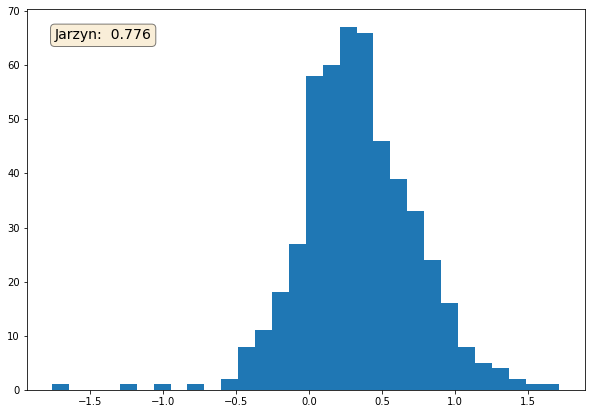

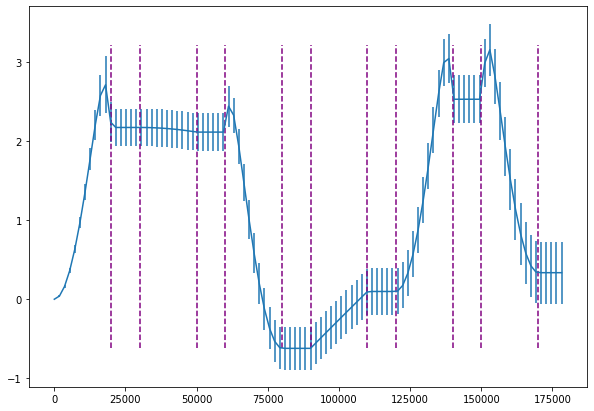

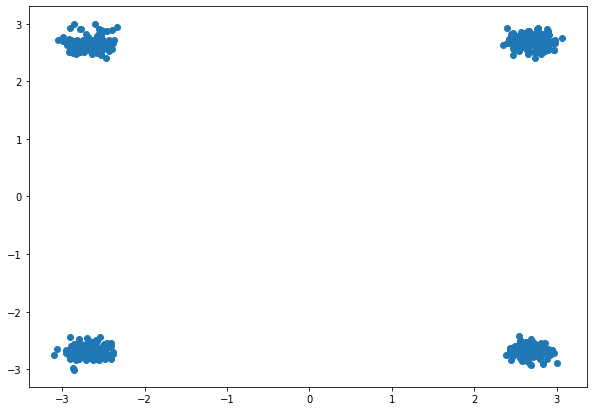

In [57]:
# step 6: save the results

cfq_batch_sweep.saveSimulationResult(simResult, U0_1, timeOrStep = 'step', save = True, save_final_state = True)